In [67]:
import numpy as np
import cv2
from skimage import io
from numba import jit
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore")


In [68]:
@jit
def assign_points_to_clusters(img, centers, points_cluster):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            dist = np.sqrt(np.sum((img[i, j, :] - centers) ** 2, axis=1))
            points_cluster[i, j] = np.argmin(dist)
    return points_cluster


In [69]:
@jit
def compute_new_centers(img, points_cluster, centers):
    for i in range(centers.shape[0]):
        centers[i, :] = np.mean(img[points_cluster == i, :], axis=0)
    return centers


In [70]:
@jit
def get_indices_clusters_less_than_min_size(img, points_cluster, centers, min_size):
    # find the id of clusters with less than min_size points
    unique, counts = np.unique(points_cluster, return_counts=True)
    small_clusters = unique[counts < min_size]
    # find indices of small clusters
    small_clusters = np.where(np.isin(unique, small_clusters))[0]
    return small_clusters


In [71]:
@jit
def get_indices_clusters_more_than_max_deviation_and_new_centers(
    img, points_cluster, centers, max_deviation, min_size
):
    new_centers = np.zeros((0, 3))
    large_clusters_idx = []
    for i in range(len(centers)):
        mean = centers[i]
        points_in_cluster = img[points_cluster == i, :]
        if points_in_cluster.shape[0] == 0:
            large_clusters_idx.append(i)
            continue
        std = np.std(points_in_cluster, axis=(0, 1))
        if std > max_deviation and points_in_cluster.shape[0] > 2 * min_size:
            std = np.std(points_in_cluster, axis=(0))
            new_centers = np.vstack((new_centers, mean + std))
            new_centers = np.vstack((new_centers, mean - std))
            large_clusters_idx.append(i)
    # print("new centers", new_centers)
    # print("large clusters", large_clusters_idx)
    return new_centers, large_clusters_idx


In [72]:
@jit
def get_indices_clusters_with_less_than_min_distance_and_new_centers(
    img, points_cluster, centers, min_distance
):
    new_centers = np.zeros((0, 3))
    clusters_to_delete = set()
    visited = set()
    for i in range(centers.shape[0]):
        for j in range(i + 1, centers.shape[0]):
            if (
                np.sqrt(
                    np.sum((centers[i, :] - centers[j, :]) ** 2)) < min_distance
                and i not in visited
                and j not in visited
            ):
                mew_center = (centers[i, :] + centers[j, :]) / 2
                new_centers = np.vstack((new_centers, mew_center))
                clusters_to_delete.add(i)
                clusters_to_delete.add(j)
                visited.add(i)
                visited.add(j)
    return new_centers, list(clusters_to_delete)


In [73]:
def isodata_new(
    img,
    max_iter,
    threshold,
    min_size,
    max_deviation,
    min_distance,
    max_num_clusters,
    verbose=False,
):
    img = img.copy()
    img = img.astype(np.float32)
    img_width = img.shape[1]
    img_height = img.shape[0]
    centers = []
    # make initial centers equally spaced
    for i in range(max_num_clusters):
        centers.append(
            [
                int(255 / (max_num_clusters + 1)) * (i + 1),
                int(255 / (max_num_clusters + 1)) * (i + 1),
                0,
            ]
        )
    centers = np.array(centers)
    # print("initial centers", centers)
    points_cluster = np.zeros((img_height, img_width))
    points_cluster = assign_points_to_clusters(img, centers, points_cluster)
    it = 0
    while it < max_iter:
        # calculate new centers
        old_points_cluster = points_cluster.copy()
        centers = compute_new_centers(img, points_cluster, centers)
        points_cluster = assign_points_to_clusters(img, centers, points_cluster)

        (
            new_centers,
            clusters_to_delete,
        ) = get_indices_clusters_with_less_than_min_distance_and_new_centers(
            img, points_cluster, centers, min_distance
        )
        if verbose:
            print("based on distance we need to delete: ", len(clusters_to_delete))
        clusters_to_delete3 = get_indices_clusters_less_than_min_size(
            img, points_cluster, centers, min_size
        )
        if verbose:
            print("based on size we need to delete: ", len(clusters_to_delete3))
        (
            new_centers2,
            clusters_to_delete2,
        ) = get_indices_clusters_more_than_max_deviation_and_new_centers(
            img, points_cluster, centers, max_deviation, min_size
        )
        if verbose:
            print("based on deviation we need to delete: ", len(clusters_to_delete2))
        # print("clusters to delete", new_centers)
        new_centers = np.vstack((new_centers, new_centers2))
        clusters_to_delete.extend(clusters_to_delete2)
        clusters_to_delete.extend(clusters_to_delete3)
        # remove clusters
        centers = np.delete(centers, clusters_to_delete, axis=0)
        # add new centers
        centers = np.vstack((centers, new_centers))
        # reassign points to clusters
        # print("it", it, "centers", centers.shape[0])
        # print("points_cluster", np.unique(points_cluster))
        points_cluster = assign_points_to_clusters(img, centers, points_cluster)
        # if count of points which changed cluster is less than threshold, stop
        if (
            np.sum(old_points_cluster != points_cluster) / len(points_cluster)
            < threshold
        ):
            break
        it += 1
    # change the color of the clusters randomly
    delta = 255 / centers.shape[0]
    for i in range(centers.shape[0]):
        centers[i, :] = [
            int(centers[i, 0] + delta * i),
            int(centers[i, 1] + delta * i),
            int(centers[i, 2] + delta * i),
        ]
    # color the clusters in the image
    for i in range(centers.shape[0]):
        img[points_cluster == i, :] = centers[i, :]
    print("img shape", img.shape)
    return img, points_cluster, centers

img shape (353, 378, 3)
number of centers:  5


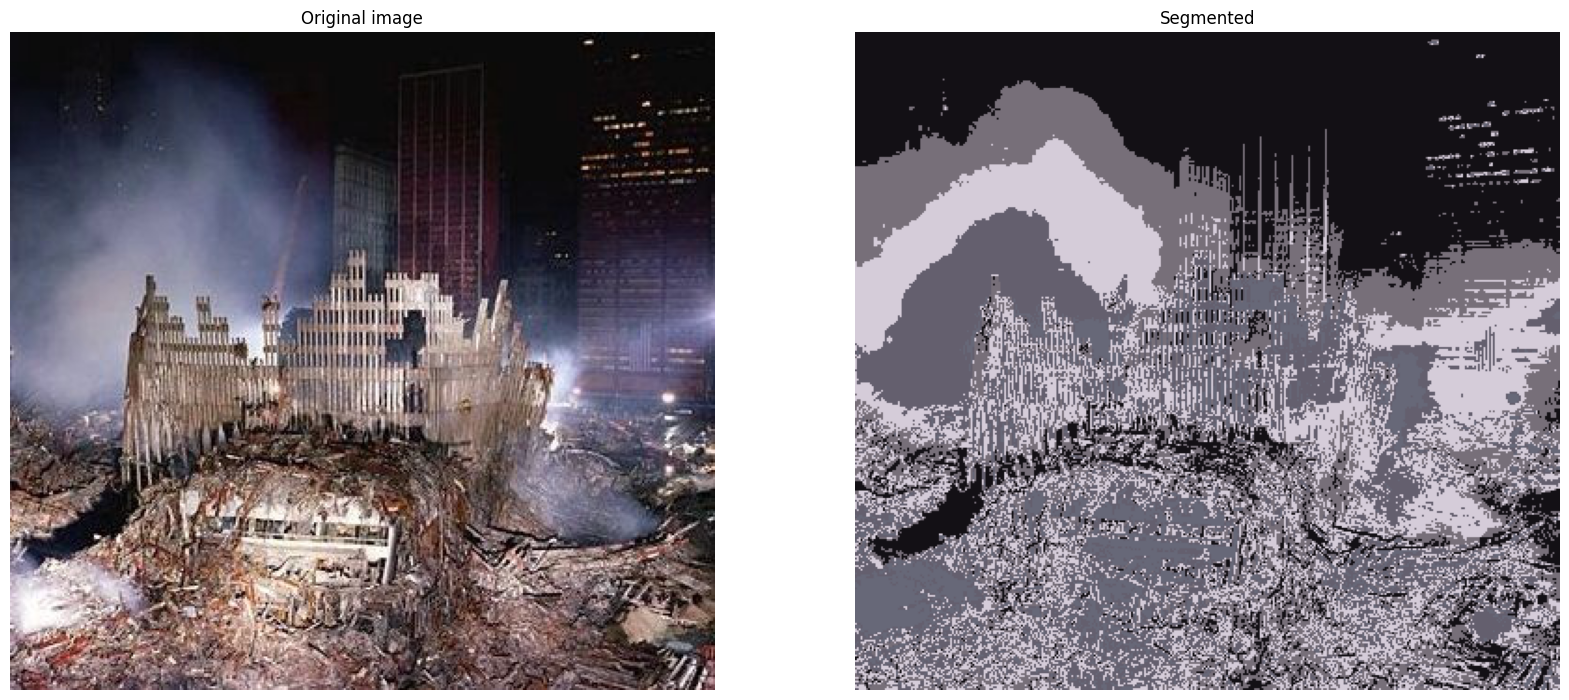

In [76]:
# Load the image
image_original = cv2.imread("./dataset/non-flooded/1005.jpg")

# show the original image size
img_size = image_original.shape

image = image_original.copy()

# # resize the image
# image = cv2.resize(image_original, (100, 100))

# Convert the image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply ISODATA algorithm
segmented_image, points_clusters, centers = isodata_new(
    image,
    max_iter=100,
    threshold=0.05,
    min_size=15,
    max_deviation=25,
    min_distance=10,
    max_num_clusters=4,
)

segmented_image = segmented_image.astype(np.uint8)

# # resize the result to the original image size
# segmented_image = cv2.resize(segmented_image, (img_size[1], img_size[0]))

print("number of centers: ", len(centers))

# # save the result to txt file
# np.savetxt("centers.txt", segmented_image.reshape(-1, 3), fmt="%d")

# Display the result
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_original)
plt.title("Original image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented")
plt.axis("off")
plt.show()


max std:  27.09052662205615
min distance between centers:  13.490737563232042


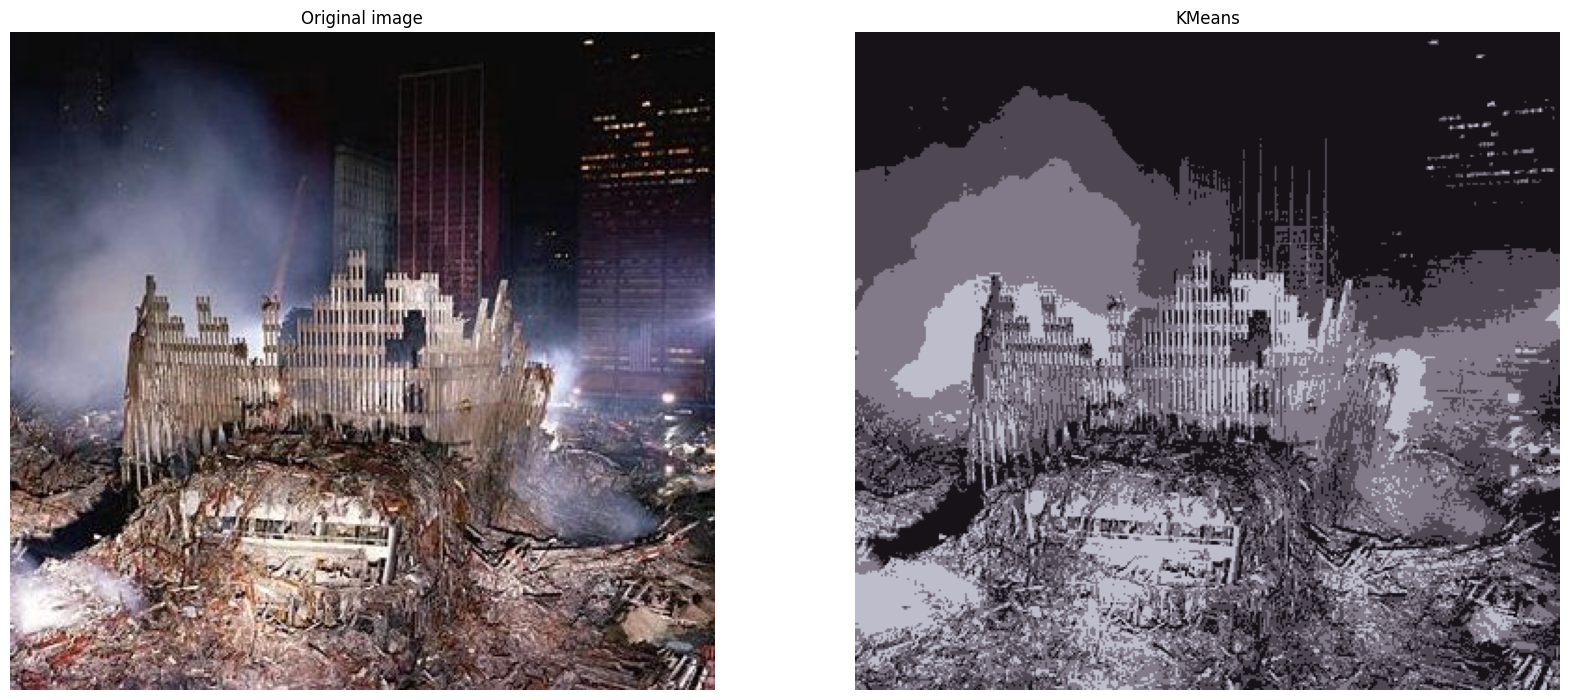

In [75]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(image.reshape(-1, 3))

segmented_image_kmeans = kmeans.cluster_centers_[kmeans.labels_]

segmented_image_kmeans = segmented_image_kmeans.reshape(image.shape).astype(np.uint8)

centers = np.floor(kmeans.cluster_centers_).astype(np.uint8)

kmeans_labels = np.zeros(
    (segmented_image_kmeans.shape[0], segmented_image_kmeans.shape[1])
)

for i in range(segmented_image_kmeans.shape[0]):
    for j in range(segmented_image_kmeans.shape[1]):
        for z in range(centers.shape[0]):
            if np.all(segmented_image_kmeans[i, j, :] == centers[z, :]):
                kmeans_labels[i, j] = z


stds = []
for i in range(len(kmeans.cluster_centers_)):
    points_in_cluster = image[kmeans_labels == i, :]
    if points_in_cluster.shape[0] == 0:
        continue
    points_in_cluster = points_in_cluster.reshape(-1, 3)
    std = np.std(points_in_cluster, axis=(0))
    stds.append(std)

print("max std: ", np.max(stds))

distances = []

for center in centers:
    # print the distance between the center and the other centers except itself
    centers_without_center = centers[~np.all(centers == center, axis=1)]
    distances.append(
        np.min(np.sqrt(np.sum((center - centers_without_center) ** 2, axis=1)))
    )

print("min distance between centers: ", np.min(distances))

# Display the result
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_original)
plt.title("Original image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(segmented_image_kmeans)
plt.title("KMeans")
plt.axis("off")
plt.show()